In [2]:
pip install torch

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 38.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 51.8 MB/s eta 0:00:0000:0100:01
Using cached typing_extensions-4.13.2-py3-none-any.whl (45 kB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Usin

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Simple U-Net definition (from previous message)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.upconv2(b)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        return torch.sigmoid(self.final(d1))  # sigmoid for binary mask


In [12]:
# Fake grayscale image with a circle mask
def generate_sample(size=128):
    image = np.random.rand(size, size)
    mask = np.zeros((size, size))
    cx, cy = size//2, size//2
    radius = size//4
    y, x = np.ogrid[:size, :size]
    mask_area = (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2
    mask[mask_area] = 1
    return image, mask

img_np, mask_np = generate_sample()
input_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


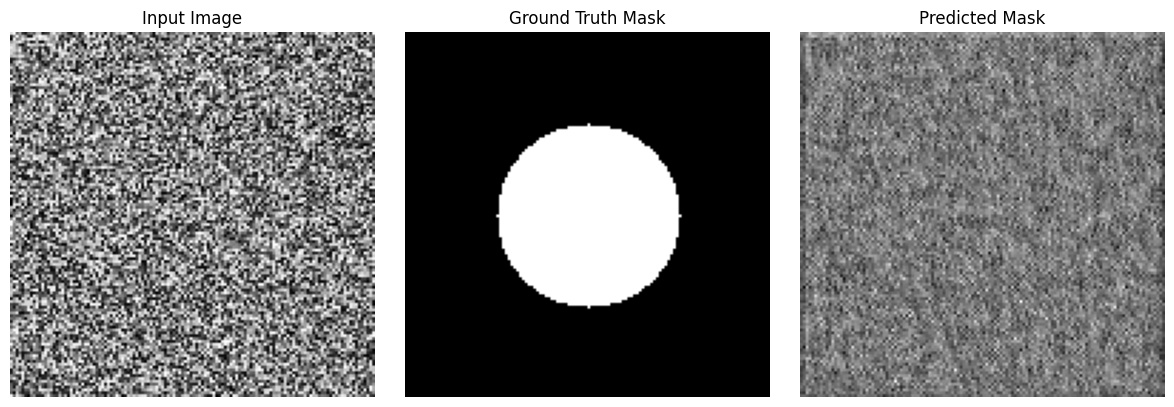

In [13]:
model = UNet()
output = model(input_tensor)

# Convert output to NumPy
pred_mask = output.detach().squeeze().numpy()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_np, cmap='gray')
axs[0].set_title('Input Image')
axs[1].imshow(mask_np, cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted Mask')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()
